# Installs/Imports

In [2]:
!pip install ultralytics

In [3]:
# System and file handling
# import sys
import os
# import re
import glob
import random
import yaml
import shutil
from shutil import copyfile
import json

# Data manipulation and visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# from matplotlib.patches import Rectangle
import seaborn as sns
from scipy.spatial.distance import jensenshannon
import time

# Image processing and display
import IPython.display as display
from PIL import Image
import cv2

# YOLO model from Ultralytics
import ultralytics
from ultralytics import YOLO

In [4]:
ultralytics.checks()

Ultralytics 8.3.127 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
Setup complete ✅ (4 CPUs, 31.4 GB RAM, 6281.6/8062.4 GB disk)


In [5]:
# No Weights & Biases (W&B)
! wandb disabled

W&B disabled.


In [6]:
class CFG:
    DEBUG = False
    # DEBUG = True
    FRACTION = 0.05 if DEBUG else 1.0
    SEED = 42

    TARGET_RATIOS = {'train': 0.80, 'valid': 0.15, 'test': 0.05}

    # Class map from dataset description
    PPE_CLASSES = {
        0: "Hardhat",
        1: "Mask",
        2: "NO-Hardhat",
        3: "NO-Mask",
        4: "NO-Safety Vest",
        5: "Person",
        6: "Safety Cone",
        7: "Safety Vest",
        8: "Machinery",
        9: "Vehicle"
    }

    # Training parameters
    EPOCHS = 3 if DEBUG else 100  # Increased to 100 epochs
    BATCH_SIZE = 4 if DEBUG else 12  # Kept at 12
    IMGSZ = 640  # Image size remains 640x640
    RECT = False  # No change
    VERBOSE = False  # No change
    SHOW_LABELS = False  # No change
    SHOW_CONF = False  # No change
    SHOW_BOXES = False  # No change
    BASE_MODEL = 'yolo11n.pt'  # No change
    DEVICE = "cuda"  # No change (assuming GPU is available)

    # Additional hyperparameters
    LR0 = 0.001  # Lower initial learning rate
    LRF = 0.005  # Lower final learning rate factor
    WEIGHT_DECAY = 0.001  # Increased weight decay
    WARMUP_EPOCHS = 5.0  # Longer warmup period
    COS_LR = True  # Enable cosine learning rate schedule
    PATIENCE = 20  # Early stopping patience
    DROPOUT = 0.1  # Add dropout
    HSV_H = 0.02  # Slightly increased color jitter
    HSV_S = 0.8
    HSV_V = 0.5
    MIXUP = 0.2  # Add mixup augmentation

    # Paths
    CSS_DATA_PATH = '/kaggle/input/construction-site-safety-image-dataset-roboflow/css-data'
    OUTPUT_PATH = './'
    WORKING_PATH = "/kaggle/working/"
    FOLDERS = ["train", "valid", "test"]

    # Define the path to save the training results
    TRAIN_RESULTS = f"{WORKING_PATH}/train_results.csv"
    MODEL_PATH = f'{WORKING_PATH}/runs/detect/train/weights/best.pt'
    OUTPUT_MODEL_PATH = f'{WORKING_PATH}/best.pt'
    METADATA_PATH = f'{WORKING_PATH}/metadata.json'

# EDA

## Directoy contents

In [7]:
for folder in CFG.FOLDERS:
    image_path = os.path.join(CFG.CSS_DATA_PATH, folder, "images")
    label_path = os.path.join(CFG.CSS_DATA_PATH, folder, "labels")

    images = set(f.rsplit(".", 1)[0] for f in os.listdir(image_path) if f.endswith((".jpg", ".png")))
    labels = set(f.rsplit(".", 1)[0] for f in os.listdir(label_path) if f.endswith(".txt"))

    missing_labels = images - labels  # Imagens sem labels
    missing_images = labels - images  # Labels sem imagens

    print(f"📂 {folder.upper()} SET:")
    print(f" - Total Images: {len(images)}")
    print(f" - Total Labels: {len(labels)}")
    print(f" - Sample Image Names: {list(images)[:2]}")
    print(f" - Sample Label Names: {list(labels)[:2]}")
    print(f" - Missing Labels: {len(missing_labels)} → {list(missing_labels)[:2]}")
    print(f" - Missing Images: {len(missing_images)} → {list(missing_images)[:2]}")
    print(" ")

📂 TRAIN SET:
 - Total Images: 2605
 - Total Labels: 2605
 - Sample Image Names: ['youtube-44_jpg.rf.c4c437c06a7372f5fa6c627e99611d50', '2009_002883_jpg.rf.41f48cf928eb3adba9c69e73c5b81e94']
 - Sample Label Names: ['youtube-44_jpg.rf.c4c437c06a7372f5fa6c627e99611d50', '2009_002883_jpg.rf.41f48cf928eb3adba9c69e73c5b81e94']
 - Missing Labels: 0 → []
 - Missing Images: 0 → []
 
📂 VALID SET:
 - Total Images: 114
 - Total Labels: 114
 - Sample Image Names: ['-1079-_png_jpg.rf.19092a3937930012f9fd9c1ce57f5a7b', 'youtube-504_jpg.rf.23771986686856ac7d350cea84ddf611']
 - Sample Label Names: ['-1079-_png_jpg.rf.19092a3937930012f9fd9c1ce57f5a7b', 'youtube-504_jpg.rf.23771986686856ac7d350cea84ddf611']
 - Missing Labels: 0 → []
 - Missing Images: 0 → []
 
📂 TEST SET:
 - Total Images: 82
 - Total Labels: 82
 - Sample Image Names: ['construction-675-_jpg.rf.bb4a05441be707256175e04929da3478', 'construction-192-_jpg.rf.56dd5c4c1396c6ad01be4fbec3bca46f']
 - Sample Label Names: ['construction-675-_jpg.rf.

📂 TRAIN SET:


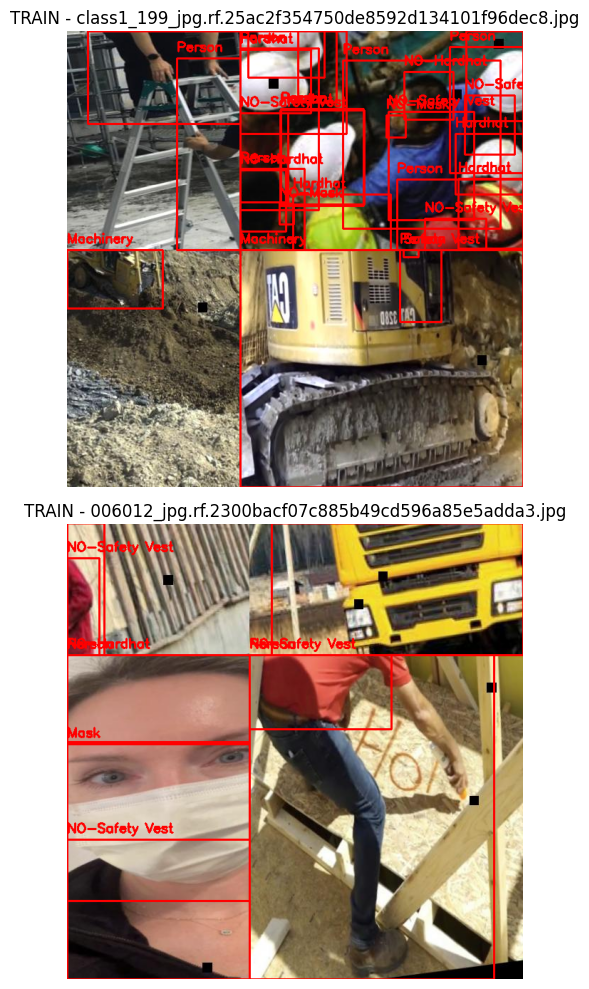


📂 VALID SET:


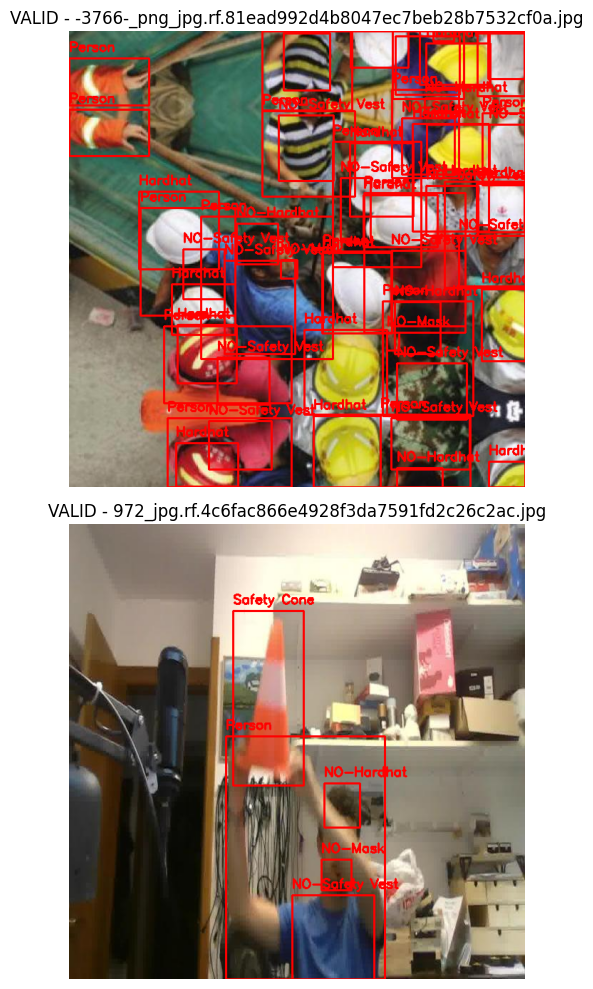


📂 TEST SET:


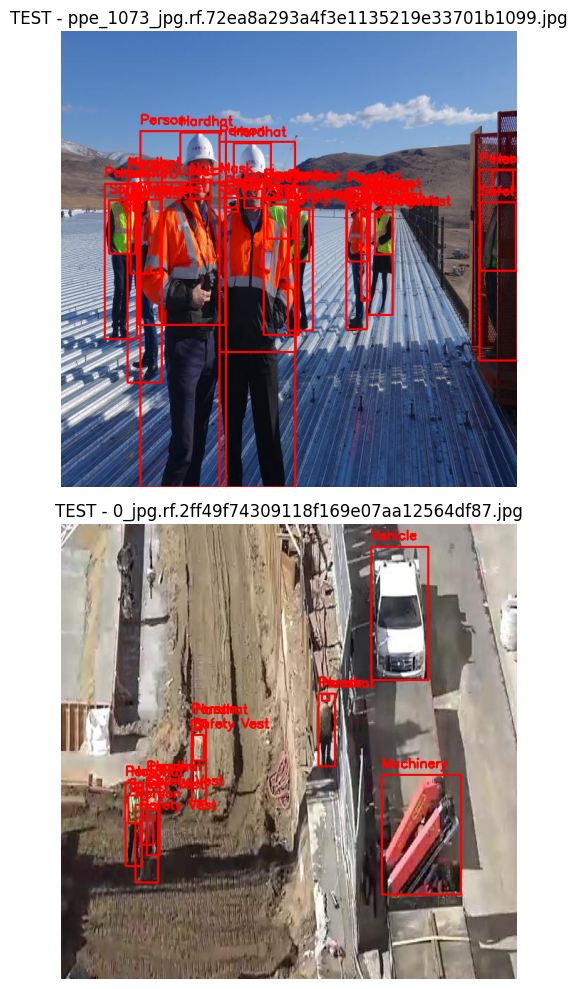

In [8]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random

def draw_bboxes(image_path, label_path, class_map):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    h, w, _ = img.shape
    if not os.path.exists(label_path):
        return img
    with open(label_path, 'r') as f:
        labels = f.readlines()
    for label in labels:
        class_id, x_center, y_center, bbox_width, bbox_height = map(float, label.strip().split())
        class_id = int(class_id)
        x_center, y_center, bbox_width, bbox_height = x_center * w, y_center * h, bbox_width * w, bbox_height * h
        x_min = int(x_center - bbox_width / 2)
        y_min = int(y_center - bbox_height / 2)
        x_max = int(x_center + bbox_width / 2)
        y_max = int(y_center + bbox_height / 2)
        color = (255, 0, 0)
        cv2.rectangle(img, (x_min, y_min), (x_max, y_max), color, 2)
        class_name = class_map.get(class_id, "Unknown")
        cv2.putText(img, class_name, (x_min, y_min - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)
    return img

def display_images_with_labels(folders, data_path, class_map, num_samples=2, seed=42):
    random.seed(seed)
    for folder in folders:
        print(f"📂 {folder.upper()} SET:")
        image_path = os.path.join(data_path, folder, "images")
        label_path = os.path.join(data_path, folder, "labels")
        images = [f for f in os.listdir(image_path) if f.endswith((".jpg", ".png"))]
        if not images:
            print(f" - No images found in {image_path}")
            print("")
            continue
        sample_images = random.sample(images, min(num_samples, len(images)))
        plt.figure(figsize=(15, 5 * len(sample_images)))
        for i, image_name in enumerate(sample_images, 1):
            img_file = os.path.join(image_path, image_name)
            label_file = os.path.join(label_path, image_name.rsplit(".", 1)[0] + ".txt")
            annotated_img = draw_bboxes(img_file, label_file, class_map)
            plt.subplot(len(sample_images), 1, i)
            plt.imshow(annotated_img)
            plt.title(f"{folder.upper()} - {image_name}")
            plt.axis("off")
        plt.tight_layout()
        plt.show()
        print("")

display_images_with_labels(
    folders=CFG.FOLDERS,
    data_path=CFG.CSS_DATA_PATH,
    class_map=CFG.PPE_CLASSES,
    num_samples=2,
    seed=CFG.SEED
)

## Lables

In [9]:
# Number of label files to display per folder
num_samples = 3

# Read label files from each folder
for folder in CFG.FOLDERS:
    label_path = os.path.join(CFG.CSS_DATA_PATH, folder, "labels")
    label_files = [f for f in os.listdir(label_path) if f.endswith(".txt")]

    print(f"📂 {folder.upper()} LABELS CONTENT:")

    # Display content of up to num_samples label files
    for label_file in label_files[:num_samples]:
        file_path = os.path.join(label_path, label_file)

        with open(file_path, "r") as f:
            content = f.readlines()

        print(f"📄 {label_file}:")
        for line in content:
            print(f"  {line.strip()}")  # Display without extra line breaks
        print("-" * 50)

📂 TRAIN LABELS CONTENT:
📄 youtube-270_jpg.rf.9ae5283f885f67c55f351ac2d03e2053.txt:
  9 0.56171875 0.0234375 0.0578125 0.046875
  5 0.20703125 0.1703125 0.0328125 0.0859375
  7 0.21171875 0.165625 0.0140625 0.03125
  8 0.2125 0.26953125 0.425 0.5390625
  4 0.8 0.178125 0.4 0.35625
  1 0.865625 0.16875 0.26875 0.30625
  5 0.8 0.309375 0.4 0.61875
  8 0.35 0.88125 0.284375 0.2375
  9 0.8 0.809375 0.4 0.38125
--------------------------------------------------
📄 Image_1009_jpg.rf.42a85f154507fc3c69facf93bbb1d22b.txt:
  8 0.15078125 0.18203125 0.3015625 0.3640625
  6 0.6087540979471843 0.8078125 0.05098179201145392 0.084375
  6 0.5584546532861385 0.76640625 0.027144302673454135 0.05
  6 0.5972267992918655 0.72421875 0.02236589600572696 0.0421875
  6 0.5509694172899565 0.73828125 0.02231135200509069 0.0375
  6 0.12307004193191222 0.9203125 0.05268974267981754 0.096875
  6 0.19350126794241174 0.84296875 0.03829997867599957 0.06875
  6 0.2556745512810479 0.80390625 0.030323846674090583 0.054687

## Classes along the dataset

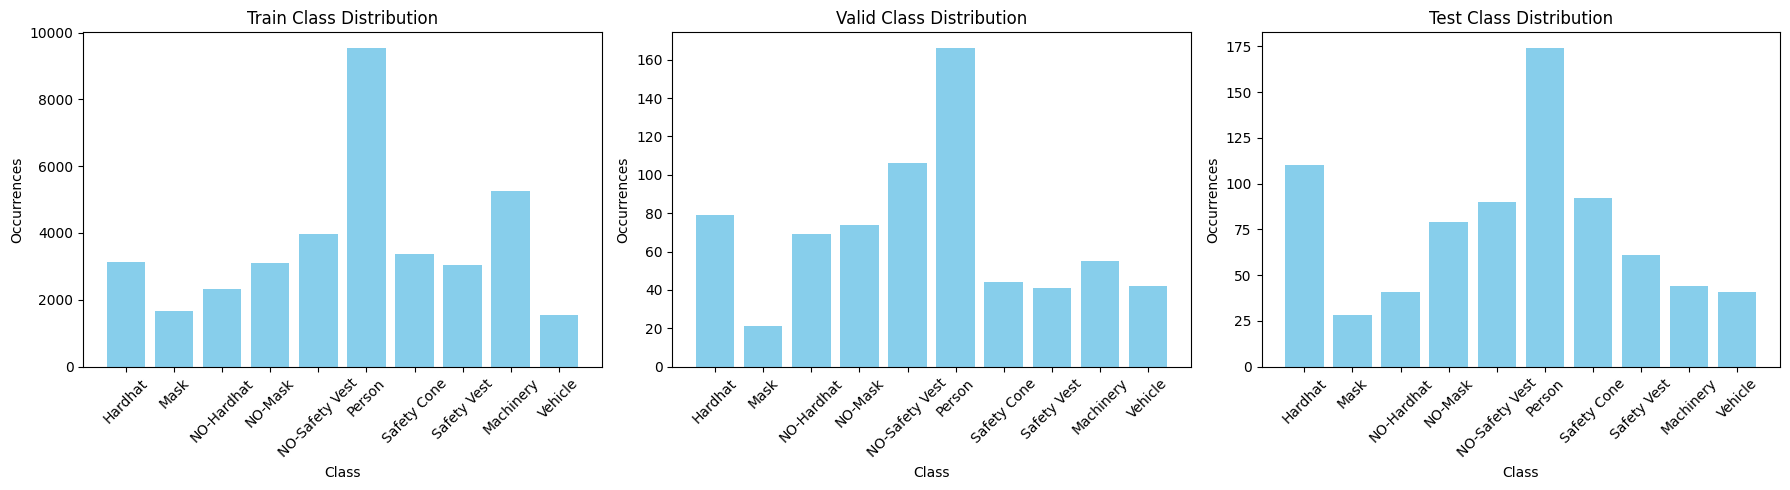

In [10]:
# Initialize class counters
class_counts = {folder: {cls: 0 for cls in CFG.PPE_CLASSES.keys()} for folder in CFG.FOLDERS}

# Count occurrences of each class in train and validation datasets
for folder in CFG.FOLDERS:
    label_path = os.path.join(CFG.CSS_DATA_PATH, folder, "labels")
    label_files = [f for f in os.listdir(label_path) if f.endswith(".txt")]

    for label_file in label_files:
        file_path = os.path.join(label_path, label_file)
        
        with open(file_path, "r") as f:
            lines = f.readlines()
        
        for line in lines:
            class_id = int(line.split()[0])  # Extract class ID from each annotation
            class_counts[folder][class_id] += 1  # Increment class count

# Plot class distribution with three subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))  # Adjust for three plots

for i, folder in enumerate(CFG.FOLDERS):
    counts = class_counts[folder]
    classes = [CFG.PPE_CLASSES[k] for k in counts.keys()]
    values = list(counts.values())

    axes[i].bar(classes, values, color="skyblue")
    axes[i].set_title(f"{folder.capitalize()} Class Distribution")
    axes[i].set_xlabel("Class")
    axes[i].set_ylabel("Occurrences")
    axes[i].tick_params(axis="x", rotation=45)

plt.tight_layout()
plt.show()

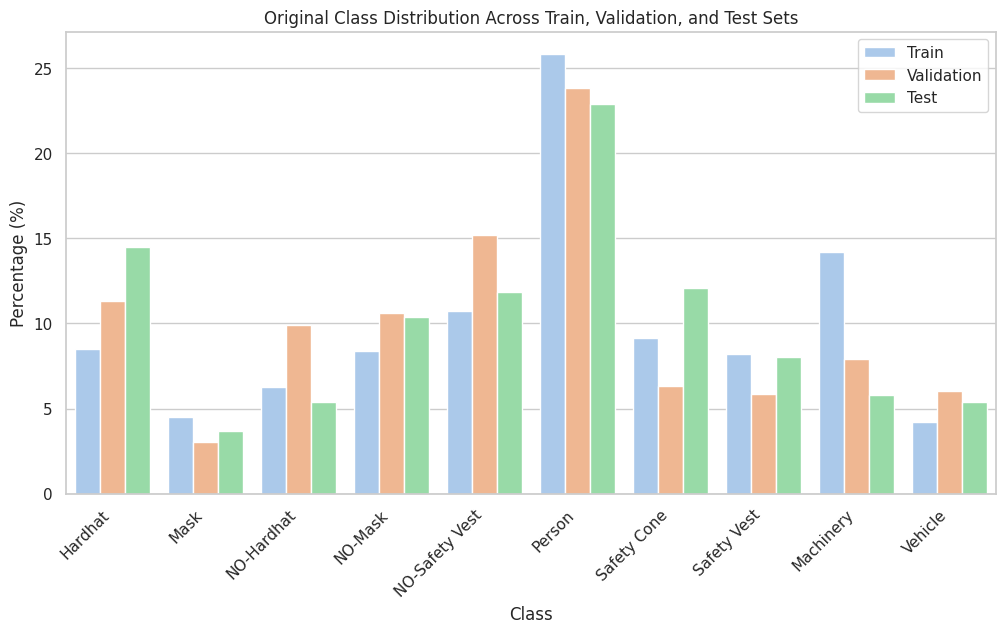

In [11]:
# Initialize class counters
class_counts = {folder: {cls: 0 for cls in CFG.PPE_CLASSES.keys()} for folder in CFG.FOLDERS}

# Count occurrences of each class in train, validation, and test datasets
for folder in CFG.FOLDERS:
    label_path = os.path.join(CFG.CSS_DATA_PATH, folder, "labels")
    label_files = [f for f in os.listdir(label_path) if f.endswith(".txt")]

    for label_file in label_files:
        file_path = os.path.join(label_path, label_file)
        
        with open(file_path, "r") as f:
            lines = f.readlines()
        
        for line in lines:
            class_id = int(line.split()[0])  # Extract class ID from each annotation
            class_counts[folder][class_id] += 1  # Increment class count

# Convert to percentages
class_percentages = {
    folder: {cls: (count / sum(class_counts[folder].values())) * 100 if sum(class_counts[folder].values()) > 0 else 0
             for cls, count in class_counts[folder].items()}
    for folder in CFG.FOLDERS
}

# Convert to DataFrame for plotting
df_plot = pd.DataFrame({
    "Class": list(CFG.PPE_CLASSES.values()) * 3,  # Repeat classes for each dataset
    "Percentage": list(class_percentages["train"].values()) + 
                  list(class_percentages["valid"].values()) + 
                  list(class_percentages["test"].values()),
    "Dataset": ["Train"] * len(class_percentages["train"]) + 
               ["Validation"] * len(class_percentages["valid"]) + 
               ["Test"] * len(class_percentages["test"])
})

# Set theme and color palette
sns.set_theme(style="whitegrid")
palette = sns.color_palette("pastel")

# Plot using sns.barplot()
plt.figure(figsize=(12, 6))
sns.barplot(x="Class", y="Percentage", hue="Dataset", data=df_plot, palette=palette)

# Labels and formatting
plt.xlabel("Class")
plt.ylabel("Percentage (%)")
plt.title("Original Class Distribution Across Train, Validation, and Test Sets")
plt.xticks(rotation=45, ha="right")
plt.legend()

# Show the plot
plt.show()


In [12]:
# Convert to percentages
class_percentages = {
    folder: {cls: (count / sum(class_counts[folder].values())) * 100 if sum(class_counts[folder].values()) > 0 else 0
             for cls, count in class_counts[folder].items()}
    for folder in CFG.FOLDERS
}

# Convert percentages to arrays
train_dist = np.array(list(class_percentages["train"].values()))
valid_dist = np.array(list(class_percentages["valid"].values()))
test_dist = np.array(list(class_percentages["test"].values()))

# Compute standard deviation (spread of the distribution)
train_std = np.std(train_dist)
valid_std = np.std(valid_dist)
test_std = np.std(test_dist)

# Compute Coefficient of Variation (CV) for each dataset
train_cv = (train_std / np.mean(train_dist)) * 100
valid_cv = (valid_std / np.mean(valid_dist)) * 100
test_cv = (test_std / np.mean(test_dist)) * 100

# Compute Jensen-Shannon Divergence
jsd_train_valid = jensenshannon(train_dist, valid_dist)
jsd_train_test = jensenshannon(train_dist, test_dist)

# Print results
print(f"📊 Standard Deviation of Class Distribution:")
print(f"   Train: {train_std:.2f}, Valid: {valid_std:.2f}, Test: {test_std:.2f}")

print(f"\n📊 Coefficient of Variation (Lower is better):")
print(f"   Train: {train_cv:.2f}%, Valid: {valid_cv:.2f}%, Test: {test_cv:.2f}%")

print(f"\n📊 Jensen-Shannon Divergence (Lower is better):")
print(f"   Train vs Valid: {jsd_train_valid:.4f}, Train vs Test: {jsd_train_test:.4f}")

📊 Standard Deviation of Class Distribution:
   Train: 5.97, Valid: 5.66, Test: 5.46

📊 Coefficient of Variation (Lower is better):
   Train: 59.66%, Valid: 56.55%, Test: 54.61%

📊 Jensen-Shannon Divergence (Lower is better):
   Train vs Valid: 0.1193, Train vs Test: 0.1264


In [13]:
# Initialize an empty dictionary to store class counts
classes_dict = {}

# Iterate over dataset splits
for subset_folder in CFG.FOLDERS:
    label_folder = glob.glob(os.path.join(CFG.CSS_DATA_PATH, subset_folder, 'labels', '*.txt'))
    cl = []
    
    # Read annotation files
    for anno_file in label_folder:
        with open(anno_file, 'r') as f:
            lines = [line.strip() for line in f.readlines()]
            cl.extend([line.split()[0] for line in lines])  # Extract class ID correctly
    
    # Count occurrences of each class
    cl_count = {str(c): cl.count(str(c)) for c in range(10)}  # Ensure all classes (0-9) are included
    classes_dict[subset_folder] = cl_count

# Convert dictionary to DataFrame
df_class_distribution = pd.DataFrame(classes_dict).fillna(0).astype(int)

# Rename index to represent class names
df_class_distribution.index.name = "Class ID"

# Print the DataFrame
print(df_class_distribution)

          train  valid  test
Class ID                    
0          3145     79   110
1          1651     21    28
2          2317     69    41
3          3097     74    79
4          3962    106    90
5          9532    166   174
6          3366     44    92
7          3033     41    61
8          5247     55    44
9          1545     42    41


In [14]:
# Classes from PPE dataset (0-9)
classes = list(CFG.PPE_CLASSES.keys())

# Initialize an empty list to store image metadata
data = []

# Iterate over train, valid, and test folders
for folder in CFG.FOLDERS:
    label_path = os.path.join(CFG.CSS_DATA_PATH, folder, 'labels')
    label_files = glob.glob(os.path.join(label_path, '*.txt'))

    for label_file in label_files:
        # Extract image filename (without extension)
        img_name = os.path.basename(label_file).replace('.txt', '')

        # Read the label file and count occurrences of each class
        class_counts = {cls: 0 for cls in CFG.PPE_CLASSES.keys()}  # Initialize all classes with 0
        with open(label_file, 'r') as f:
            lines = f.readlines()
            for line in lines:
                class_id = int(line.split()[0])  # Extract class ID
                class_counts[class_id] += 1  # Count occurrences

        # Create a row with the filename, origin, and class occurrences
        row = {'filename': img_name, 'origin': folder}
        row.update(class_counts)

        # Append to the dataset
        data.append(row)

# Convert list to DataFrame
df_total = pd.DataFrame(data)

# Print dataset summary
print(f"📊 Total images: {len(df_total)}")
print(df_total.head())

📊 Total images: 2801
                                            filename origin  0  1  2  3  4  5  \
0  youtube-270_jpg.rf.9ae5283f885f67c55f351ac2d03...  train  0  1  0  0  1  2   
1  Image_1009_jpg.rf.42a85f154507fc3c69facf93bbb1...  train  0  0  1  1  1  1   
2  youtube-693_jpg.rf.c5a5784a786a21f09fa8df370f7...  train  1  0  0  1  0  3   
3  IMG_0871_mp4-10_jpg.rf.316b943fdf8f56161e0005b...  train  0  2  0  0  2  2   
4  ka_00884_png_jpg.rf.7e1eb708ba18a96826b2667c8d...  train  0  0  1  1  0  1   

    6  7  8  9  
0   0  1  2  2  
1  12  0  1  3  
2   2  2  2  1  
3   0  0  2  0  
4   3  1  4  0  


In [15]:
df_total.describe()

0            1            2            3            4  \
count  2801.000000  2801.000000  2801.000000  2801.000000  2801.000000   
mean      1.190289     0.606926     0.866476     1.160300     1.484470   
std       2.282822     1.019143     1.256421     1.824342     1.627177   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     0.000000     0.000000     0.000000     0.000000   
50%       0.000000     0.000000     1.000000     1.000000     1.000000   
75%       1.000000     1.000000     1.000000     2.000000     2.000000   
max      22.000000    10.000000    13.000000    21.000000    16.000000   

                 5            6            7            8            9  
count  2801.000000  2801.000000  2801.000000  2801.000000  2801.000000  
mean      3.524456     1.250268     1.119243     1.908604     0.581221  
std       2.903359     4.419258     2.203258     1.744236     1.426506  
min       0.000000     0.000000     0.000000     0.000000     0.000000  
25%       2.000000     0.000000     0.000000     1.000000     0.000000  
50%       3.000000     0.000000     0.000000     2.000000     0.000000  
75%       4.000000     0.000000     1.000000     3.000000     1.000000  
max      24.000000    46.000000    20.000000    13.000000    15.000000

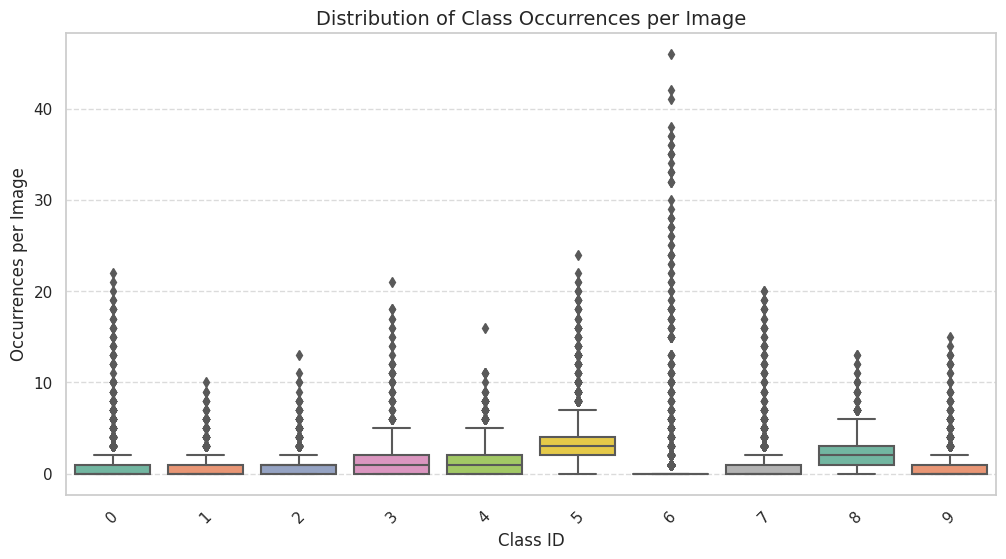

In [16]:
# Set figure size
plt.figure(figsize=(12, 6))

# Create boxplot
sns.boxplot(data=df_total.iloc[:, 2:], palette="Set2")

# Set title and labels
plt.title("Distribution of Class Occurrences per Image", fontsize=14)
plt.xlabel("Class ID", fontsize=12)
plt.ylabel("Occurrences per Image", fontsize=12)

# Show plot
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()


# Fixing the Datasets

## 1. Total_df

In [17]:
# Classes from PPE dataset (0-9)
classes = list(CFG.PPE_CLASSES.keys())

# Initialize an empty list to store image metadata
data = []

# Iterate over train, valid, and test folders
for folder in CFG.FOLDERS:
    label_path = os.path.join(CFG.CSS_DATA_PATH, folder, 'labels')
    label_files = glob.glob(os.path.join(label_path, '*.txt'))

    for label_file in label_files:
        # Extract image filename (without extension)
        img_name = os.path.basename(label_file).replace('.txt', '')

        # Initialize class presence as 0 for all classes
        class_presence = {cls: 0 for cls in CFG.PPE_CLASSES.keys()}

        # Read the label file and mark presence of each class
        with open(label_file, 'r') as f:
            lines = f.readlines()
            for line in lines:
                class_id = int(line.split()[0])  # Extract class ID
                class_presence[class_id] = 1  # Mark presence (1)

        # Create a row with the filename, origin, and class presence
        row = {'filename': img_name, 'origin': folder}
        row.update(class_presence)

        # Append to the dataset
        data.append(row)

# Convert list to DataFrame
df_total = pd.DataFrame(data)

# Print dataset summary
print(f"📊 Total images: {len(df_total)}")
print(df_total.head())

📊 Total images: 2801
                                            filename origin  0  1  2  3  4  5  \
0  youtube-270_jpg.rf.9ae5283f885f67c55f351ac2d03...  train  0  1  0  0  1  1   
1  Image_1009_jpg.rf.42a85f154507fc3c69facf93bbb1...  train  0  0  1  1  1  1   
2  youtube-693_jpg.rf.c5a5784a786a21f09fa8df370f7...  train  1  0  0  1  0  1   
3  IMG_0871_mp4-10_jpg.rf.316b943fdf8f56161e0005b...  train  0  1  0  0  1  1   
4  ka_00884_png_jpg.rf.7e1eb708ba18a96826b2667c8d...  train  0  0  1  1  0  1   

   6  7  8  9  
0  0  1  1  1  
1  1  0  1  1  
2  1  1  1  1  
3  0  0  1  0  
4  1  1  1  0  


In [18]:
# Create empty lists to store rows for each dataset
train_data = []
valid_data = []
test_data = []

# Define target proportions
target_ratios = CFG.TARGET_RATIOS  # {'train': 0.80, 'valid': 0.15, 'test': 0.05}
total_images = len(df_total)
target_sizes = {subset: int(total_images * target_ratios[subset]) for subset in CFG.FOLDERS}

# Initialize counters for class distribution in each set
class_distribution = {
    'train': {cls: 0 for cls in CFG.PPE_CLASSES.keys()},
    'valid': {cls: 0 for cls in CFG.PPE_CLASSES.keys()},
    'test': {cls: 0 for cls in CFG.PPE_CLASSES.keys()}
}

# Shuffle df_total to randomize image order
df_total = df_total.sample(frac=1, random_state=CFG.SEED).reset_index(drop=True)

# Step 1: Fill TRAIN dataset first
for _, row in df_total.iterrows():
    if len(train_data) < target_sizes['train']:
        train_data.append(row)
        for cls in CFG.PPE_CLASSES.keys():
            class_distribution['train'][cls] += row[cls]

# Remaining images to be distributed between valid and test
remaining_images = df_total[~df_total['filename'].isin([x['filename'] for x in train_data])]

# Step 2: Distribute remaining images to VALID and TEST
for _, row in remaining_images.iterrows():
    if len(valid_data) < target_sizes['valid']:
        valid_data.append(row)
        for cls in CFG.PPE_CLASSES.keys():
            class_distribution['valid'][cls] += row[cls]
    elif len(test_data) < target_sizes['test']:
        test_data.append(row)
        for cls in CFG.PPE_CLASSES.keys():
            class_distribution['test'][cls] += row[cls]

# Step 3: If any images are left, assign them to train
remaining_images = df_total[~df_total['filename'].isin([x['filename'] for x in train_data + valid_data + test_data])]

for _, row in remaining_images.iterrows():
    train_data.append(row)
    for cls in CFG.PPE_CLASSES.keys():
        class_distribution['train'][cls] += row[cls]

# Convert lists to DataFrames
df_train = pd.DataFrame(train_data)
df_valid = pd.DataFrame(valid_data)
df_test = pd.DataFrame(test_data)

In [19]:
# Total number of processed images
total_assigned = len(df_train) + len(df_valid) + len(df_test)

# Actual proportions
train_ratio = len(df_train) / total_assigned
valid_ratio = len(df_valid) / total_assigned
test_ratio = len(df_test) / total_assigned

# Display proportions
print(f"✅ Total assigned images: {total_assigned} (Expected: {len(df_total)})")
print(f"📊 Train: {len(df_train)} images ({train_ratio:.2%})")
print(f"📊 Validation: {len(df_valid)} images ({valid_ratio:.2%})")
print(f"📊 Test: {len(df_test)} images ({test_ratio:.2%})")

# Check if any images are missing
missing_images = set(df_total['filename']) - set(df_train['filename']) - set(df_valid['filename']) - set(df_test['filename'])

if missing_images:
    print(f"⚠️ {len(missing_images)} image(s) were not assigned!")
    print("🔍 Displaying details of missing images in df_total:")

    # Display details of missing images
    missing_df = df_total[df_total['filename'].isin(missing_images)]
    print(missing_df)  # Displays the DataFrame in the notebook
else:
    print("✅ No images were lost!")

✅ Total assigned images: 2801 (Expected: 2801)
📊 Train: 2241 images (80.01%)
📊 Validation: 420 images (14.99%)
📊 Test: 140 images (5.00%)
✅ No images were lost!


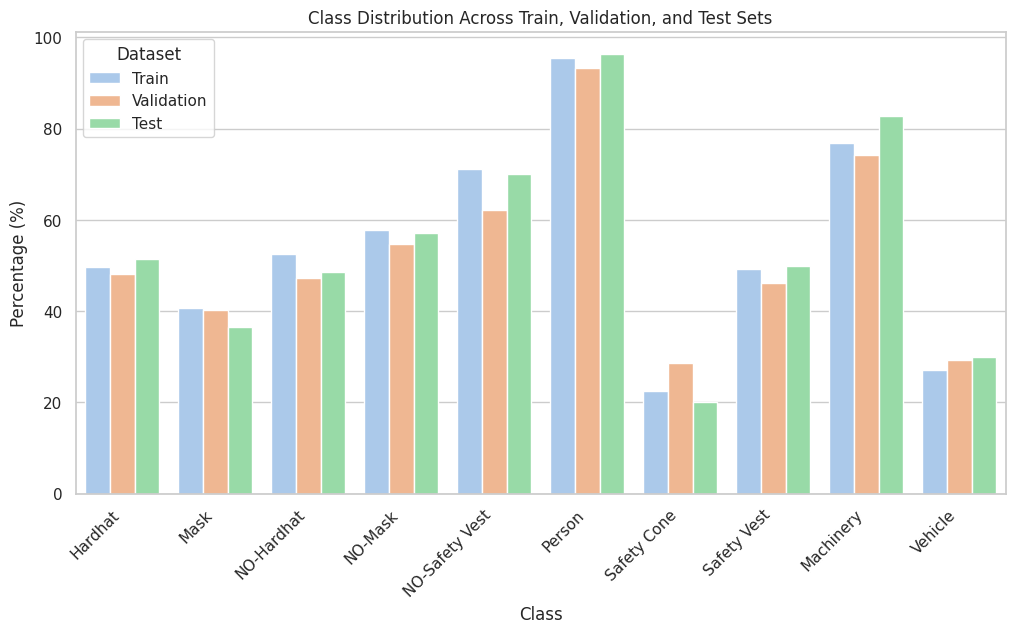

In [20]:
# Set theme and pastel color palette
sns.set_theme(style="whitegrid")  # Define o tema

# Calculate class distributions in percentage
def compute_class_percentage(df):
    total = len(df)
    return {cls: (df[cls].sum() / total) * 100 for cls in CFG.PPE_CLASSES.keys()}

train_percentages = compute_class_percentage(df_train)
valid_percentages = compute_class_percentage(df_valid)
test_percentages = compute_class_percentage(df_test)

# Convert to a DataFrame for Seaborn
df_plot = pd.DataFrame({
    "Class": list(CFG.PPE_CLASSES.values()) * 3,  # Repete as classes 3 vezes (para cada conjunto)
    "Percentage": list(train_percentages.values()) + list(valid_percentages.values()) + list(test_percentages.values()),
    "Dataset": ["Train"] * len(train_percentages) + ["Validation"] * len(valid_percentages) + ["Test"] * len(test_percentages)
})

# Create the plot using sns.barplot
plt.figure(figsize=(12, 6))
sns.barplot(x="Class", y="Percentage", hue="Dataset", data=df_plot, palette="pastel")

# Labels and formatting
plt.xlabel("Class")
plt.ylabel("Percentage (%)")
plt.title("Class Distribution Across Train, Validation, and Test Sets")
plt.xticks(rotation=45, ha="right")

# Show the plot
plt.show()


In [21]:
# Convert percentages to arrays
train_dist = np.array(list(train_percentages.values()))
valid_dist = np.array(list(valid_percentages.values()))
test_dist = np.array(list(test_percentages.values()))

# Compute standard deviation (how spread out the class distributions are)
train_std = np.std(train_dist)
valid_std = np.std(valid_dist)
test_std = np.std(test_dist)

# Compute Coefficient of Variation (CV) to assess balance
train_cv = (train_std / np.mean(train_dist)) * 100
valid_cv = (valid_std / np.mean(valid_dist)) * 100
test_cv = (test_std / np.mean(test_dist)) * 100

# Compute Jensen-Shannon divergence between Train-Valid and Train-Test
jsd_train_valid = jensenshannon(train_dist, valid_dist)
jsd_train_test = jensenshannon(train_dist, test_dist)

# Print results
print(f"📊 Standard Deviation of Class Distribution:")
print(f"   Train: {train_std:.2f}, Valid: {valid_std:.2f}, Test: {test_std:.2f}")

print(f"\n📊 Coefficient of Variation (Lower is better):")
print(f"   Train: {train_cv:.2f}%, Valid: {valid_cv:.2f}%, Test: {test_cv:.2f}%")

print(f"\n📊 Jensen-Shannon Divergence (Lower is better):")
print(f"   Train vs Valid: {jsd_train_valid:.4f}, Train vs Test: {jsd_train_test:.4f}")


📊 Standard Deviation of Class Distribution:
   Train: 21.19, Valid: 18.94, Test: 22.34

📊 Coefficient of Variation (Lower is better):
   Train: 39.02%, Valid: 36.13%, Test: 41.15%

📊 Jensen-Shannon Divergence (Lower is better):
   Train vs Valid: 0.0276, Train vs Test: 0.0209


**Now the datasets are clearly better stratified**

In [22]:
for folder in CFG.FOLDERS:
    os.makedirs(os.path.join(CFG.WORKING_PATH, folder, "images"), exist_ok=True)
    os.makedirs(os.path.join(CFG.WORKING_PATH, folder, "labels"), exist_ok=True)

# Function to move files to the correct locations
def move_files(df, subset):
    for _, row in df.iterrows():
        filename = row["filename"]
        origin = row["origin"]

        # Define source paths
        img_src = os.path.join(CFG.CSS_DATA_PATH, origin, "images", filename + ".jpg")
        label_src = os.path.join(CFG.CSS_DATA_PATH, origin, "labels", filename + ".txt")

        # Define destination paths
        img_dst = os.path.join(CFG.WORKING_PATH, subset, "images", filename + ".jpg")
        label_dst = os.path.join(CFG.WORKING_PATH, subset, "labels", filename + ".txt")

        # Move the files
        if os.path.exists(img_src):
            shutil.copy(img_src, img_dst)
        else:
            print(f"⚠️ Image not found: {img_src}")

        if os.path.exists(label_src):
            shutil.copy(label_src, label_dst)
        else:
            print(f"⚠️ Label not found: {label_src}")

# Move the files for train, valid, and test
move_files(df_train, "train")
move_files(df_valid, "valid")
move_files(df_test, "test")

print("✅ Dataset reorganization complete!")


✅ Dataset reorganization complete!


In [23]:
# ✅ Store the original class distribution BEFORE augmentation
original_class_counts = {cls: 0 for cls in CFG.PPE_CLASSES.keys()}

for _, row in df_train.iterrows():
    for cls in CFG.PPE_CLASSES.keys():
        if row[cls] == 1:
            original_class_counts[cls] += 1

# ✅ Convert to numpy array for later comparison
original_counts = np.array(list(original_class_counts.values()), dtype=np.float64)

In [24]:
original_counts

array([       1112,         911,        1175,        1295,        1597,        2142,         504,        1105,        1721,         610])

In [25]:
# Invert class dictionary (name → id)
PPE_CLASSES_INV = {v: k for k, v in CFG.PPE_CLASSES.items()}

# Classes for augmentation
target_classes = ["Safety Cone", "Vehicle"]
excluded_classes = ["Person", "Machinery"]

# Directories for images and labels
img_dir = os.path.join(CFG.WORKING_PATH, "train", "images")
label_dir = os.path.join(CFG.WORKING_PATH, "train", "labels")

# Counter for cloned images
cloned_count = 0

# Create new images and labels for augmentation
for _, row in df_train.iterrows():
    filename = row["filename"]

    # Check if the image contains at least one of the target classes
    contains_target = any(row[PPE_CLASSES_INV[cls]] == 1 for cls in target_classes)
    
    # Allow images with up to 1 occurrence of "Person" or "Machinery"
    excluded_count = sum(row[PPE_CLASSES_INV[cls]] for cls in excluded_classes)
    
    if contains_target and excluded_count <= 1:
        # Define paths for image and label
        img_path = os.path.join(img_dir, filename + ".jpg")
        label_path = os.path.join(label_dir, filename + ".txt")

        if os.path.exists(img_path) and os.path.exists(label_path):
            # Read the original image
            img = cv2.imread(img_path)

            # Apply transformations: flipping, rotation, brightness
            augmentations = {
                "flipped": cv2.flip(img, 1),  # Horizontal flip
                "rotated": cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE),  # Rotate 90 degrees
                "brightened": cv2.convertScaleAbs(img, alpha=1.2, beta=20)  # Increase brightness
            }

            for aug_type, aug_img in augmentations.items():
                # Create new filenames
                new_filename = f"{filename}_{aug_type}"
                new_img_path = os.path.join(img_dir, new_filename + ".jpg")
                new_label_path = os.path.join(label_dir, new_filename + ".txt")

                # Save augmented image
                cv2.imwrite(new_img_path, aug_img)

                # Copy label file (bounding boxes remain unchanged)
                with open(label_path, "r") as f:
                    label_data = f.readlines()

                with open(new_label_path, "w") as f:
                    f.writelines(label_data)

                cloned_count += 1

print(f"✅ {cloned_count} augmented images created (using flipping, rotation, and brightness adjustments).")

✅ 663 augmented images created (using flipping, rotation, and brightness adjustments).


In [26]:
# Define new DataFrame for augmented training set
df_train_augmented = []

# Paths for images and labels
train_img_dir = os.path.join(CFG.WORKING_PATH, "train", "images")
train_label_dir = os.path.join(CFG.WORKING_PATH, "train", "labels")

# Get all label files
label_files = glob.glob(os.path.join(train_label_dir, "*.txt"))

# Rebuild DataFrame by reading label files
for label_file in label_files:
    filename = os.path.basename(label_file).replace(".txt", "")

    # Read label file
    class_presence = {cls: 0 for cls in CFG.PPE_CLASSES.keys()}
    with open(label_file, "r") as f:
        lines = f.readlines()
        for line in lines:
            class_id = int(line.split()[0])  # Extract class ID
            class_presence[class_id] = 1  # Mark presence of class

    # Append to new DataFrame
    row = {"filename": filename, "origin": "train"}
    row.update(class_presence)
    df_train_augmented.append(row)

# Convert to DataFrame
df_train_augmented = pd.DataFrame(df_train_augmented)

# Print summary
print(f"📊 New Train Dataset: {len(df_train_augmented)} images (after augmentation).")


📊 New Train Dataset: 2904 images (after augmentation).


📊 Standard Deviation of Class Distribution:
   Before: 474.96, After: 491.86

📊 Coefficient of Variation (Lower is better):
   Before: 39.02%, After: 31.31%

📊 Jensen-Shannon Divergence (Lower is better): 0.0494

📊 Relative Change per Class (%):
   Hardhat: 25.63%
   Mask: 28.32%
   NO-Hardhat: 27.83%
   NO-Mask: 29.19%
   NO-Safety Vest: 27.99%
   Person: 26.33%
   Safety Cone: 97.02%
   Safety Vest: 26.33%
   Machinery: 4.18%
   Vehicle: 69.84%


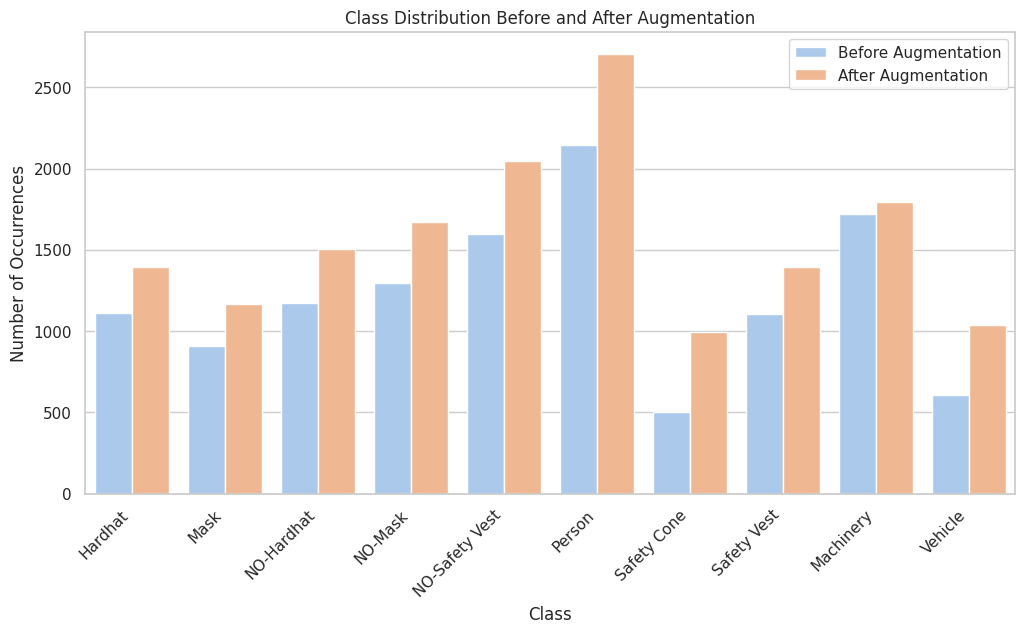

In [27]:
# ✅ Compute new class distribution from df_train_augmented
augmented_class_counts = {cls: 0 for cls in CFG.PPE_CLASSES.keys()}
for _, row in df_train_augmented.iterrows():
    for cls in CFG.PPE_CLASSES.keys():
        if row[cls] == 1:
            augmented_class_counts[cls] += 1

# Convert to numpy arrays
augmented_counts = np.array(list(augmented_class_counts.values()), dtype=np.float64)

# ✅ Compute standard deviation and coefficient of variation BEFORE augmentation
original_mean, original_std = np.mean(original_counts), np.std(original_counts)
original_cv = (original_std / original_mean) * 100

# ✅ Compute standard deviation and coefficient of variation AFTER augmentation
augmented_mean, augmented_std = np.mean(augmented_counts), np.std(augmented_counts)
augmented_cv = (augmented_std / augmented_mean) * 100

# ✅ Jensen-Shannon Divergence (Lower is better)
jsd = jensenshannon(original_counts, augmented_counts)

# ✅ Compute percentage change per class
relative_change = ((augmented_counts - original_counts) / original_counts) * 100

# ✅ Print results
print(f"📊 Standard Deviation of Class Distribution:")
print(f"   Before: {original_std:.2f}, After: {augmented_std:.2f}")

print(f"\n📊 Coefficient of Variation (Lower is better):")
print(f"   Before: {original_cv:.2f}%, After: {augmented_cv:.2f}%")

print(f"\n📊 Jensen-Shannon Divergence (Lower is better): {jsd:.4f}")

print("\n📊 Relative Change per Class (%):")
for cls, change in zip(CFG.PPE_CLASSES.values(), relative_change):
    print(f"   {cls}: {change:.2f}%")

# ✅ Plot class distribution BEFORE and AFTER augmentation
df_plot = pd.DataFrame({
    "Class": np.array(list(CFG.PPE_CLASSES.values())),  
    "Before Augmentation": original_counts,
    "After Augmentation": augmented_counts
})

# Melt for Seaborn
df_plot_melted = df_plot.melt(id_vars=["Class"], var_name="Dataset", value_name="Occurrences")

# ✅ Plot using Seaborn
plt.figure(figsize=(12, 6))
sns.barplot(x="Class", y="Occurrences", hue="Dataset", data=df_plot_melted, palette="pastel")
plt.xlabel("Class")
plt.ylabel("Number of Occurrences")
plt.title("Class Distribution Before and After Augmentation")
plt.xticks(rotation=45, ha="right")
plt.legend()
plt.show()


In [28]:
# Paths to check
img_path = os.path.join(CFG.WORKING_PATH, "train", "images")
label_path = os.path.join(CFG.WORKING_PATH, "train", "labels")

# Count files
num_images = len([f for f in os.listdir(img_path) if f.endswith(".jpg")])
num_labels = len([f for f in os.listdir(label_path) if f.endswith(".txt")])

print(f"📂 Total images in train folder: {num_images}")
print(f"📂 Total labels in train folder: {num_labels}")


📂 Total images in train folder: 2904
📂 Total labels in train folder: 2904


In [29]:
# Load the YOLO11 model (pretrained weights)
model = YOLO(CFG.BASE_MODEL) 

# Create YAML file

- Create ```data.yaml``` file properly formatted to be used by Yolo

In [30]:
### Save YAML file
def save_yaml_file(dataset_yaml, dataset_config):
    with open(dataset_yaml, "w") as f:
        yaml.dump(dataset_config, f, default_flow_style=False)
    
    print(f"✅ Dataset YAML file saved at: {dataset_yaml}")

### read yaml file created
def read_yaml_file(file_path):
    with open(file_path, 'r') as file:
        try:
            data = yaml.safe_load(file)
            return data
        except yaml.YAMLError as e:
            print("Error reading YAML:", e)
            return None

### print it with newlines
def print_yaml_data(data):
    formatted_yaml = yaml.dump(data, default_style=False)
    print(formatted_yaml)

In [31]:
# Define paths
dataset_yaml = os.path.join(CFG.WORKING_PATH, "dataset.yaml")

# Create YAML content
dataset_config = {
    "path": CFG.WORKING_PATH,  # Base path
    "train": "train/images",  # Train images folder
    "val": "valid/images",  # Validation images folder
    "test": "test/images",  # Test images folder
    "nc": len(CFG.PPE_CLASSES),  # Number of classes
    "names": list(CFG.PPE_CLASSES.values()),  # Class names
}

In [32]:
save_yaml_file(dataset_yaml, dataset_config)

✅ Dataset YAML file saved at: /kaggle/working/dataset.yaml


In [33]:
yaml_data = read_yaml_file(dataset_yaml)

if yaml_data:
    print_yaml_data(yaml_data)

names:
- Hardhat
- Mask
- NO-Hardhat
- NO-Mask
- NO-Safety Vest
- Person
- Safety Cone
- Safety Vest
- Machinery
- Vehicle
nc: 10
path: /kaggle/working/
test: test/images
train: train/images
val: valid/images



# Train

In [34]:
# Training parameters (used both in training and result logging)
train_data = {
    "epochs": CFG.EPOCHS,
    "batch": CFG.BATCH_SIZE,
    "imgsz": CFG.IMGSZ,
    "rect": CFG.RECT,
    "fraction": CFG.FRACTION,
    "seed": CFG.SEED,
    "verbose": CFG.VERBOSE,
    "show_labels": CFG.SHOW_LABELS,
    "show_conf": CFG.SHOW_CONF,
    "show_boxes": CFG.SHOW_BOXES,
    "device": CFG.DEVICE
}

In [35]:
# Start timing the training
start_time = time.time()

train_results = model.train(
    data=dataset_yaml,
    **train_data
)

# End timing
end_time = time.time()
training_duration = end_time - start_time  # Calculate duration in seconds

Ultralytics 8.3.127 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=12, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/dataset.yaml, degrees=0.0, deterministic=True, device=cuda:0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train2, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0, pretra

train: Scanning /kaggle/working/train/labels.cache... 2904 images, 17 backgrounds, 0 corrupt: 100%|██████████| 2904/2904 [00:00<?, ?it/s]

train: /kaggle/working/train/images/construction-813-_jpg.rf.b085952261fd98f2e76b8065de149b5f.jpg: 1 duplicate labels removed


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1087.0±733.8 MB/s, size: 52.9 KB)


val: Scanning /kaggle/working/valid/labels.cache... 420 images, 6 backgrounds, 0 corrupt: 100%|██████████| 420/420 [00:00<?, ?it/s]

val: /kaggle/working/valid/images/004720_jpg.rf.afc486560a4004c7cfd67910af31a29c.jpg: 1 duplicate labels removed


Plotting labels to runs/detect/train2/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000714, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.00046875), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train2
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      2.38G      1.505      3.276      1.587        197        640: 100%|██████████| 242/242 [00:36<00:00,  6.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:04<00:00,  4.38it/s]


                   all        420       5739      0.342      0.316       0.26       0.13

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      2.39G      1.488      2.233      1.597        194        640: 100%|██████████| 242/242 [00:34<00:00,  6.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:04<00:00,  4.43it/s]


                   all        420       5739      0.517      0.364      0.375      0.196

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      2.39G      1.435      2.033      1.556        251        640: 100%|██████████| 242/242 [00:34<00:00,  6.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:03<00:00,  5.02it/s]


                   all        420       5739      0.583      0.401      0.418      0.219

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      2.39G      1.414      1.958      1.536        309        640: 100%|██████████| 242/242 [00:34<00:00,  7.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:03<00:00,  5.21it/s]

                   all        420       5739      0.591      0.416      0.446      0.242



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      2.39G      1.383      1.902      1.515        262        640: 100%|██████████| 242/242 [00:34<00:00,  7.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:03<00:00,  4.87it/s]


                   all        420       5739      0.641      0.428       0.47      0.263

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      2.39G      1.365       1.84      1.498        247        640: 100%|██████████| 242/242 [00:34<00:00,  7.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:03<00:00,  5.04it/s]

                   all        420       5739       0.65      0.434      0.488      0.268



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      2.39G      1.347      1.774      1.485        244        640: 100%|██████████| 242/242 [00:34<00:00,  7.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:03<00:00,  4.91it/s]

                   all        420       5739      0.696       0.48       0.53      0.293



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      2.39G      1.324      1.723      1.464        243        640: 100%|██████████| 242/242 [00:34<00:00,  7.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:03<00:00,  5.23it/s]


                   all        420       5739      0.685      0.467      0.527      0.297

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      2.39G      1.331      1.709      1.461        239        640: 100%|██████████| 242/242 [00:34<00:00,  7.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:03<00:00,  5.36it/s]

                   all        420       5739      0.697      0.501      0.549      0.319



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      2.39G      1.305      1.674      1.447        235        640: 100%|██████████| 242/242 [00:34<00:00,  7.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:03<00:00,  5.11it/s]

                   all        420       5739      0.726      0.514      0.567      0.324



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      2.39G      1.289       1.64      1.434        216        640: 100%|██████████| 242/242 [00:34<00:00,  7.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:03<00:00,  5.32it/s]

                   all        420       5739      0.692      0.505      0.562      0.323



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      2.39G      1.283      1.616       1.43        261        640: 100%|██████████| 242/242 [00:34<00:00,  7.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:03<00:00,  4.87it/s]

                   all        420       5739       0.69      0.517      0.569      0.327



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      2.39G      1.273      1.598      1.419        318        640: 100%|██████████| 242/242 [00:34<00:00,  7.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:03<00:00,  5.26it/s]

                   all        420       5739      0.688      0.491      0.551      0.304



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      2.39G      1.261      1.574      1.417        222        640: 100%|██████████| 242/242 [00:34<00:00,  7.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:03<00:00,  5.44it/s]

                   all        420       5739       0.74       0.53      0.594      0.352



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      2.39G      1.245      1.538      1.405        343        640: 100%|██████████| 242/242 [00:34<00:00,  7.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:03<00:00,  5.39it/s]

                   all        420       5739      0.745      0.525      0.597      0.362



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      2.39G       1.23      1.511      1.392        283        640: 100%|██████████| 242/242 [00:34<00:00,  7.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:03<00:00,  5.40it/s]

                   all        420       5739       0.74      0.541      0.603       0.36



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      2.39G       1.23      1.507      1.391        200        640: 100%|██████████| 242/242 [00:34<00:00,  7.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:03<00:00,  5.16it/s]


                   all        420       5739      0.746      0.545      0.606      0.356

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      2.39G      1.215       1.48      1.383        325        640: 100%|██████████| 242/242 [00:34<00:00,  7.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:03<00:00,  5.30it/s]

                   all        420       5739      0.763      0.562      0.634      0.378



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      2.39G      1.225      1.488      1.389        206        640: 100%|██████████| 242/242 [00:34<00:00,  7.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:03<00:00,  5.40it/s]

                   all        420       5739      0.759      0.564      0.628      0.383



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      2.39G      1.215      1.471      1.377        300        640: 100%|██████████| 242/242 [00:34<00:00,  7.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:03<00:00,  5.48it/s]

                   all        420       5739       0.75      0.548      0.612      0.367



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      2.39G      1.209      1.447      1.369        247        640: 100%|██████████| 242/242 [00:34<00:00,  7.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:03<00:00,  5.28it/s]

                   all        420       5739      0.796      0.565      0.635      0.385



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      2.39G      1.191      1.428      1.363        232        640: 100%|██████████| 242/242 [00:34<00:00,  7.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:03<00:00,  5.38it/s]

                   all        420       5739      0.771      0.561      0.629      0.389



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      2.39G      1.184      1.405      1.354        328        640: 100%|██████████| 242/242 [00:34<00:00,  7.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:03<00:00,  5.43it/s]

                   all        420       5739      0.764      0.565      0.633      0.391



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      2.39G      1.187      1.408      1.355        351        640: 100%|██████████| 242/242 [00:34<00:00,  7.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:03<00:00,  5.35it/s]

                   all        420       5739      0.807      0.568      0.649        0.4



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      2.39G      1.166      1.363      1.336        241        640: 100%|██████████| 242/242 [00:34<00:00,  7.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:03<00:00,  5.34it/s]

                   all        420       5739      0.802       0.59      0.664       0.41



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      2.39G      1.165      1.356      1.338        239        640: 100%|██████████| 242/242 [00:34<00:00,  7.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:03<00:00,  5.30it/s]

                   all        420       5739      0.783      0.596      0.662      0.406



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      2.39G       1.16      1.366      1.337        174        640: 100%|██████████| 242/242 [00:34<00:00,  7.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:03<00:00,  5.43it/s]

                   all        420       5739      0.803      0.599       0.67      0.418



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      2.39G       1.16      1.339      1.329        281        640: 100%|██████████| 242/242 [00:34<00:00,  7.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:03<00:00,  5.10it/s]

                   all        420       5739      0.801      0.588      0.661      0.409



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      2.39G      1.142      1.311      1.324        148        640: 100%|██████████| 242/242 [00:34<00:00,  7.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:03<00:00,  5.47it/s]

                   all        420       5739      0.806      0.587      0.667      0.418



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      2.39G      1.155      1.338      1.335        274        640: 100%|██████████| 242/242 [00:34<00:00,  7.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:03<00:00,  5.41it/s]

                   all        420       5739      0.799      0.589      0.669      0.414



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      2.39G      1.137      1.315      1.322        246        640: 100%|██████████| 242/242 [00:34<00:00,  7.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:03<00:00,  5.47it/s]

                   all        420       5739      0.803      0.592      0.662       0.41



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      2.39G      1.135      1.309      1.318        291        640: 100%|██████████| 242/242 [00:34<00:00,  7.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:03<00:00,  5.29it/s]

                   all        420       5739      0.814      0.608      0.679      0.427



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      2.39G      1.131      1.301      1.311        181        640: 100%|██████████| 242/242 [00:34<00:00,  7.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:03<00:00,  5.09it/s]

                   all        420       5739      0.795      0.599      0.673       0.41



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      2.39G      1.131      1.292      1.315        215        640: 100%|██████████| 242/242 [00:34<00:00,  7.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:03<00:00,  5.47it/s]

                   all        420       5739      0.815      0.601      0.682      0.424



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      2.39G      1.118      1.282      1.307        308        640: 100%|██████████| 242/242 [00:34<00:00,  7.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:03<00:00,  5.41it/s]

                   all        420       5739      0.817      0.614      0.685      0.435



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      2.39G      1.119      1.274      1.299        345        640: 100%|██████████| 242/242 [00:34<00:00,  7.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:03<00:00,  5.54it/s]

                   all        420       5739       0.81      0.618       0.69      0.435



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      2.39G      1.106      1.254      1.293        219        640: 100%|██████████| 242/242 [00:34<00:00,  7.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:03<00:00,  5.45it/s]

                   all        420       5739      0.829      0.613      0.692      0.442



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      2.39G      1.111      1.264      1.302        263        640: 100%|██████████| 242/242 [00:34<00:00,  7.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:03<00:00,  5.29it/s]


                   all        420       5739      0.834      0.622      0.703      0.449

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      2.39G      1.109      1.249      1.296        297        640: 100%|██████████| 242/242 [00:34<00:00,  7.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:03<00:00,  5.53it/s]

                   all        420       5739      0.795      0.631      0.692      0.431



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      2.39G      1.098      1.237       1.29        241        640: 100%|██████████| 242/242 [00:34<00:00,  7.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:03<00:00,  5.41it/s]

                   all        420       5739       0.84      0.619        0.7      0.449



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      2.39G      1.099      1.232       1.29        218        640: 100%|██████████| 242/242 [00:34<00:00,  7.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:03<00:00,  5.58it/s]

                   all        420       5739      0.816      0.627      0.699      0.449



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      2.39G      1.096      1.222      1.286        299        640: 100%|██████████| 242/242 [00:34<00:00,  7.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:03<00:00,  5.41it/s]

                   all        420       5739      0.825      0.627      0.699       0.45



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      2.39G      1.086      1.215      1.284        261        640: 100%|██████████| 242/242 [00:34<00:00,  7.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:03<00:00,  5.50it/s]

                   all        420       5739      0.834      0.624      0.701       0.45



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      2.39G      1.079      1.215      1.282        273        640: 100%|██████████| 242/242 [00:34<00:00,  7.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:03<00:00,  5.28it/s]

                   all        420       5739      0.848      0.617      0.701      0.451



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      2.39G      1.075      1.204      1.275        260        640: 100%|██████████| 242/242 [00:34<00:00,  7.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:03<00:00,  5.52it/s]

                   all        420       5739      0.831      0.632       0.71      0.455



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      2.39G      1.075      1.191      1.274        160        640: 100%|██████████| 242/242 [00:34<00:00,  7.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:03<00:00,  5.42it/s]

                   all        420       5739      0.832      0.644      0.715      0.465



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      2.39G      1.071      1.203      1.278        175        640: 100%|██████████| 242/242 [00:34<00:00,  7.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:03<00:00,  5.56it/s]

                   all        420       5739      0.814      0.633      0.705      0.448



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      2.39G      1.067       1.18      1.266        197        640: 100%|██████████| 242/242 [00:34<00:00,  7.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:03<00:00,  5.62it/s]

                   all        420       5739       0.84      0.638      0.717      0.468



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      2.39G      1.058      1.165      1.258        199        640: 100%|██████████| 242/242 [00:34<00:00,  7.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:03<00:00,  5.20it/s]

                   all        420       5739      0.838      0.644      0.715      0.468



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      2.39G      1.059      1.163      1.261        360        640: 100%|██████████| 242/242 [00:34<00:00,  7.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:03<00:00,  5.53it/s]

                   all        420       5739       0.82       0.65      0.713      0.464



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      2.39G      1.045      1.135      1.246        267        640: 100%|██████████| 242/242 [00:34<00:00,  7.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:03<00:00,  5.49it/s]

                   all        420       5739      0.822      0.645      0.718      0.463



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      2.39G      1.064      1.164      1.259        195        640: 100%|██████████| 242/242 [00:34<00:00,  7.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:03<00:00,  5.52it/s]

                   all        420       5739      0.843      0.646       0.72      0.468



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      2.39G      1.045      1.158      1.255        262        640: 100%|██████████| 242/242 [00:34<00:00,  7.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:03<00:00,  5.53it/s]

                   all        420       5739       0.85      0.641      0.721      0.474



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      2.39G      1.037       1.13      1.247        268        640: 100%|██████████| 242/242 [00:34<00:00,  7.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:03<00:00,  5.59it/s]

                   all        420       5739      0.839       0.65      0.724      0.476



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      2.39G      1.033      1.132      1.246        212        640: 100%|██████████| 242/242 [00:34<00:00,  7.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:03<00:00,  5.42it/s]

                   all        420       5739      0.839       0.65      0.727      0.476



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      2.39G      1.039      1.134      1.249        321        640: 100%|██████████| 242/242 [00:34<00:00,  7.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:03<00:00,  5.46it/s]

                   all        420       5739      0.849       0.65      0.728      0.477



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      2.39G       1.04      1.132      1.243        309        640: 100%|██████████| 242/242 [00:34<00:00,  7.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:03<00:00,  5.45it/s]

                   all        420       5739      0.839      0.646      0.728      0.478



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      2.39G      1.028      1.117      1.245        217        640: 100%|██████████| 242/242 [00:34<00:00,  7.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:03<00:00,  5.34it/s]

                   all        420       5739      0.839      0.652      0.724      0.476



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      2.39G      1.025      1.114      1.238        276        640: 100%|██████████| 242/242 [00:34<00:00,  7.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:03<00:00,  5.39it/s]

                   all        420       5739      0.848      0.658      0.731      0.481



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      2.39G      1.018      1.106       1.23        244        640: 100%|██████████| 242/242 [00:34<00:00,  6.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:03<00:00,  5.54it/s]

                   all        420       5739       0.85      0.658      0.734      0.477



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      2.39G      1.021      1.127      1.237        207        640: 100%|██████████| 242/242 [00:34<00:00,  7.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:03<00:00,  5.60it/s]

                   all        420       5739       0.85      0.652      0.734      0.484



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      2.39G       1.02      1.111      1.234        319        640: 100%|██████████| 242/242 [00:34<00:00,  7.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:03<00:00,  5.56it/s]

                   all        420       5739      0.862       0.65      0.731      0.488



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      2.39G      1.007      1.078       1.22        222        640: 100%|██████████| 242/242 [00:34<00:00,  7.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:03<00:00,  5.60it/s]

                   all        420       5739      0.834      0.672      0.736      0.487



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      2.39G     0.9974      1.082       1.22        201        640: 100%|██████████| 242/242 [00:34<00:00,  7.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:03<00:00,  5.48it/s]

                   all        420       5739      0.856      0.664      0.739      0.492



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      2.39G     0.9996      1.086      1.225        233        640: 100%|██████████| 242/242 [00:34<00:00,  7.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:03<00:00,  5.39it/s]

                   all        420       5739       0.85      0.664      0.738      0.487



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      2.39G     0.9952      1.083      1.224        209        640: 100%|██████████| 242/242 [00:34<00:00,  7.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:03<00:00,  5.58it/s]

                   all        420       5739      0.841      0.672       0.74      0.492



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      2.39G     0.9893      1.063      1.211        289        640: 100%|██████████| 242/242 [00:34<00:00,  7.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:03<00:00,  5.55it/s]

                   all        420       5739      0.851      0.665      0.741      0.492



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      2.39G      0.988      1.064      1.217        249        640: 100%|██████████| 242/242 [00:34<00:00,  7.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:03<00:00,  5.55it/s]

                   all        420       5739      0.848      0.668      0.742      0.497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      2.39G     0.9895      1.064      1.211        221        640: 100%|██████████| 242/242 [00:34<00:00,  7.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:03<00:00,  5.57it/s]

                   all        420       5739       0.86      0.666      0.742      0.496



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      2.39G     0.9879      1.057      1.212        215        640: 100%|██████████| 242/242 [00:34<00:00,  7.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:03<00:00,  5.47it/s]


                   all        420       5739       0.86       0.66      0.744      0.495

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      2.39G     0.9828      1.058      1.208        310        640: 100%|██████████| 242/242 [00:34<00:00,  7.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:03<00:00,  5.46it/s]

                   all        420       5739      0.858      0.668      0.746      0.497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      2.39G     0.9858      1.057      1.208        212        640: 100%|██████████| 242/242 [00:34<00:00,  7.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:03<00:00,  5.57it/s]

                   all        420       5739      0.863       0.67      0.749      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      2.39G     0.9774      1.055      1.207        236        640: 100%|██████████| 242/242 [00:34<00:00,  7.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:03<00:00,  5.43it/s]

                   all        420       5739      0.862      0.667      0.749      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      2.39G     0.9704      1.045      1.207        332        640: 100%|██████████| 242/242 [00:34<00:00,  7.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:03<00:00,  5.54it/s]

                   all        420       5739      0.869      0.668      0.749      0.498



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      2.39G     0.9716      1.043      1.202        272        640: 100%|██████████| 242/242 [00:34<00:00,  7.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:03<00:00,  5.59it/s]

                   all        420       5739      0.859      0.669       0.75      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      2.39G     0.9672      1.028      1.202        219        640: 100%|██████████| 242/242 [00:34<00:00,  7.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:03<00:00,  5.66it/s]

                   all        420       5739      0.853      0.676       0.75      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      2.39G     0.9618      1.033      1.199        315        640: 100%|██████████| 242/242 [00:34<00:00,  7.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:03<00:00,  5.41it/s]

                   all        420       5739      0.865      0.677      0.751      0.511



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      2.39G     0.9569      1.017      1.192        257        640: 100%|██████████| 242/242 [00:34<00:00,  7.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:03<00:00,  5.53it/s]

                   all        420       5739      0.866      0.675      0.752      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      2.39G     0.9583       1.03      1.198        260        640: 100%|██████████| 242/242 [00:34<00:00,  7.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:03<00:00,  5.45it/s]

                   all        420       5739      0.858      0.674      0.753       0.51



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      2.39G     0.9615      1.033      1.197        234        640: 100%|██████████| 242/242 [00:34<00:00,  7.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:03<00:00,  5.68it/s]

                   all        420       5739      0.869      0.669      0.753      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      2.39G     0.9504      1.014      1.193        208        640: 100%|██████████| 242/242 [00:34<00:00,  7.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:03<00:00,  5.25it/s]

                   all        420       5739      0.868      0.671      0.752      0.512



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      2.39G      0.941      1.022      1.192        218        640: 100%|██████████| 242/242 [00:33<00:00,  7.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:03<00:00,  5.53it/s]

                   all        420       5739      0.874      0.668      0.754      0.513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      2.39G     0.9303     0.9843      1.179        273        640: 100%|██████████| 242/242 [00:34<00:00,  7.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:03<00:00,  5.59it/s]

                   all        420       5739      0.866      0.676      0.756      0.513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      2.39G     0.9572      1.024      1.189        191        640: 100%|██████████| 242/242 [00:34<00:00,  7.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:03<00:00,  5.64it/s]

                   all        420       5739      0.854      0.677      0.755      0.509



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      2.39G     0.9368     0.9933       1.18        253        640: 100%|██████████| 242/242 [00:34<00:00,  7.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:03<00:00,  5.52it/s]

                   all        420       5739       0.87      0.678      0.755      0.514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      2.39G     0.9297     0.9854      1.177        259        640: 100%|██████████| 242/242 [00:34<00:00,  7.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:03<00:00,  5.62it/s]


                   all        420       5739      0.867      0.681      0.757      0.518

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      2.39G     0.9425     0.9999      1.181        205        640: 100%|██████████| 242/242 [00:34<00:00,  7.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:03<00:00,  5.51it/s]

                   all        420       5739      0.881      0.674      0.758      0.514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      2.39G     0.9295     0.9837      1.179        258        640: 100%|██████████| 242/242 [00:34<00:00,  7.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:03<00:00,  5.68it/s]

                   all        420       5739      0.871       0.68       0.76      0.517



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      2.39G     0.9201     0.9832      1.171        260        640: 100%|██████████| 242/242 [00:34<00:00,  7.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:03<00:00,  5.59it/s]

                   all        420       5739      0.872      0.681      0.762      0.518



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      2.39G     0.9197     0.9719      1.173        217        640: 100%|██████████| 242/242 [00:34<00:00,  7.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:03<00:00,  5.59it/s]

                   all        420       5739      0.882      0.674      0.762       0.52


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      2.39G     0.9481     0.9388      1.193        146        640: 100%|██████████| 242/242 [00:33<00:00,  7.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:03<00:00,  5.28it/s]


                   all        420       5739       0.87      0.679      0.756      0.517

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      2.39G     0.9328      0.906      1.178        149        640: 100%|██████████| 242/242 [00:33<00:00,  7.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:03<00:00,  5.08it/s]

                   all        420       5739      0.869      0.684      0.757      0.517



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      2.39G     0.9203     0.8986      1.176        114        640: 100%|██████████| 242/242 [00:33<00:00,  7.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:03<00:00,  5.50it/s]

                   all        420       5739      0.878       0.68      0.759       0.52



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      2.39G     0.9151     0.8921      1.171        141        640: 100%|██████████| 242/242 [00:33<00:00,  7.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:03<00:00,  5.51it/s]

                   all        420       5739      0.872      0.684      0.759      0.519



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      2.39G     0.9134     0.8876      1.171        267        640: 100%|██████████| 242/242 [00:33<00:00,  7.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:03<00:00,  5.63it/s]

                   all        420       5739       0.87      0.683      0.761       0.52



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      2.39G     0.9122     0.8819      1.169        116        640: 100%|██████████| 242/242 [00:33<00:00,  7.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:03<00:00,  5.55it/s]

                   all        420       5739      0.872      0.684      0.761      0.521



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      2.39G     0.8974     0.8671      1.159        117        640: 100%|██████████| 242/242 [00:33<00:00,  7.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:03<00:00,  5.66it/s]

                   all        420       5739      0.864      0.689      0.761      0.524



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      2.39G        0.9     0.8741      1.162        114        640: 100%|██████████| 242/242 [00:32<00:00,  7.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:03<00:00,  5.43it/s]


                   all        420       5739      0.873      0.683      0.761      0.523

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      2.39G     0.8937     0.8712      1.157        116        640: 100%|██████████| 242/242 [00:33<00:00,  7.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:03<00:00,  5.60it/s]

                   all        420       5739      0.867      0.688      0.761      0.524



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      2.39G     0.8972     0.8708      1.165        171        640: 100%|██████████| 242/242 [00:33<00:00,  7.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:03<00:00,  5.46it/s]

                   all        420       5739      0.867      0.687      0.763      0.524



100 epochs completed in 1.054 hours.
Optimizer stripped from runs/detect/train2/weights/last.pt, 5.5MB
Optimizer stripped from runs/detect/train2/weights/best.pt, 5.5MB

Validating runs/detect/train2/weights/best.pt...
Ultralytics 8.3.127 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11n summary (fused): 100 layers, 2,584,102 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:05<00:00,  3.18it/s]


                   all        420       5739      0.867      0.687      0.763      0.524


/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Speed: 0.2ms preprocess, 2.6ms inference, 0.0ms loss, 5.5ms postprocess per image
Results saved to runs/detect/train2


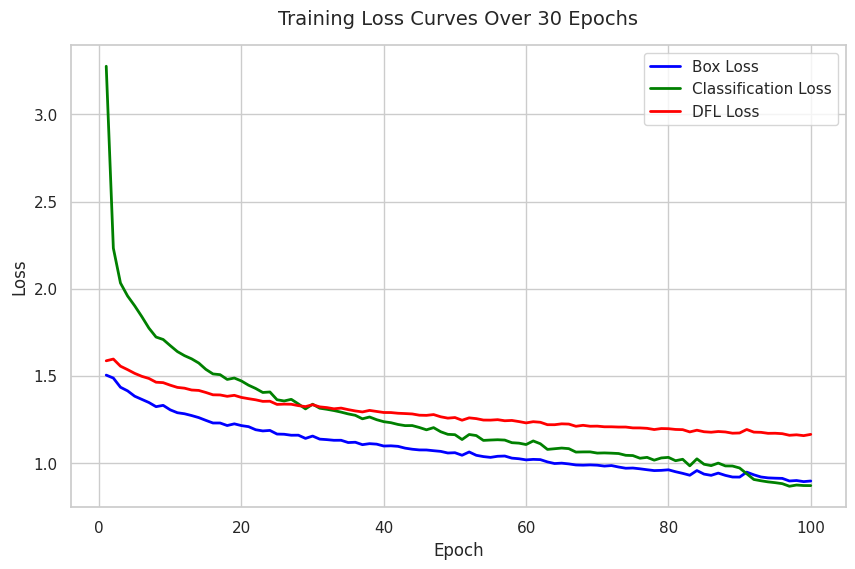

In [48]:
import pandas as pd
import matplotlib.pyplot as plt

# Path to the training results CSV file
results_path = '/kaggle/working/runs/detect/train2/results.csv'

# Load the results CSV file
results_df = pd.read_csv(results_path)

# Strip any leading/trailing whitespace from column names
results_df.columns = results_df.columns.str.strip()

# Extract relevant loss columns
# Column names in results.csv are typically like 'train/box_loss', 'train/cls_loss', 'train/dfl_loss'
epochs = results_df['epoch']
box_loss = results_df['train/box_loss']
cls_loss = results_df['train/cls_loss']
dfl_loss = results_df['train/dfl_loss']

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(epochs, box_loss, label='Box Loss', color='blue', linewidth=2)
plt.plot(epochs, cls_loss, label='Classification Loss', color='green', linewidth=2)
plt.plot(epochs, dfl_loss, label='DFL Loss', color='red', linewidth=2)

# Add titles and labels
plt.title('Training Loss Curves Over 30 Epochs', fontsize=14, pad=15)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.grid(True)
plt.legend()

plt.show()

In [37]:
# Store training metrics for later analysis
train_metrics = {
    "train_id": f"train_{pd.Timestamp.now().strftime('%Y%m%d_%H%M%S')}",  # Unique ID
    "model": CFG.BASE_MODEL,  # Model used
    "mAP50": train_results.box.map50,
    "mAP50-95": train_results.box.map,
    "Precision": train_results.box.mp,
    "Recall": train_results.box.mr,
    "train_time": round(training_duration, 2)  # Training duration in seconds
}

In [38]:
# Display only the final summary metrics
print("\n📊 Final Training Metrics:")
for metric, value in train_metrics.items():
    if isinstance(value, (int, float)):  # Check if value is numeric
        print(f"   {metric}: {value:.3f}")
    else:
        print(f"   {metric}: {value}")  # Print as is if not numeric


📊 Final Training Metrics:
   train_id: train_20250506_115707
   model: yolo11n.pt
   mAP50: 0.763
   mAP50-95: 0.524
   Precision: 0.867
   Recall: 0.687
   train_time: 3815.760


In [39]:
# Combine both training parameters and results into a new dictionary
train_summary = {**train_metrics, **train_data}

# Convert to DataFrame
train_df = pd.DataFrame([train_summary])

In [40]:
# Append results if file exists, otherwise create a new one
if os.path.exists(CFG.TRAIN_RESULTS):
    existing_df = pd.read_csv(CFG.TRAIN_RESULTS)
    updated_df = pd.concat([existing_df, train_df], ignore_index=True)
else:
    updated_df = train_df

# Save the updated DataFrame
updated_df.to_csv(CFG.TRAIN_RESULTS, index=False)

# Print confirmation message
print(f"✅ Training results saved successfully to {CFG.TRAIN_RESULTS}")

✅ Training results saved successfully to /kaggle/working//train_results.csv


In [41]:
train_df = pd.read_csv(CFG.TRAIN_RESULTS)

In [42]:
# Set display options to prevent line breaks
pd.set_option("display.width", 200)  # Increase display width
pd.set_option("display.max_columns", None)  # Show all columns

In [43]:
print(train_df)

                train_id       model     mAP50  mAP50-95  Precision    Recall  train_time  epochs  batch  imgsz   rect  fraction  seed  verbose  show_labels  show_conf  show_boxes device
0  train_20250506_115707  yolo11n.pt  0.762572  0.523702   0.866994  0.686562     3815.76     100     12    640  False       1.0    42    False        False      False       False   cuda



image 1/1 /kaggle/working/valid/images/RPReplay_Final1667001201_MP4-21_jpg.rf.19c9998d5c8e6029af7f5e5e34d14413.jpg: 640x640 2 Masks, 1 NO-Hardhat, 2 NO-Safety Vests, 4 Persons, 1 Safety Vest, 8.2ms
Speed: 1.5ms preprocess, 8.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


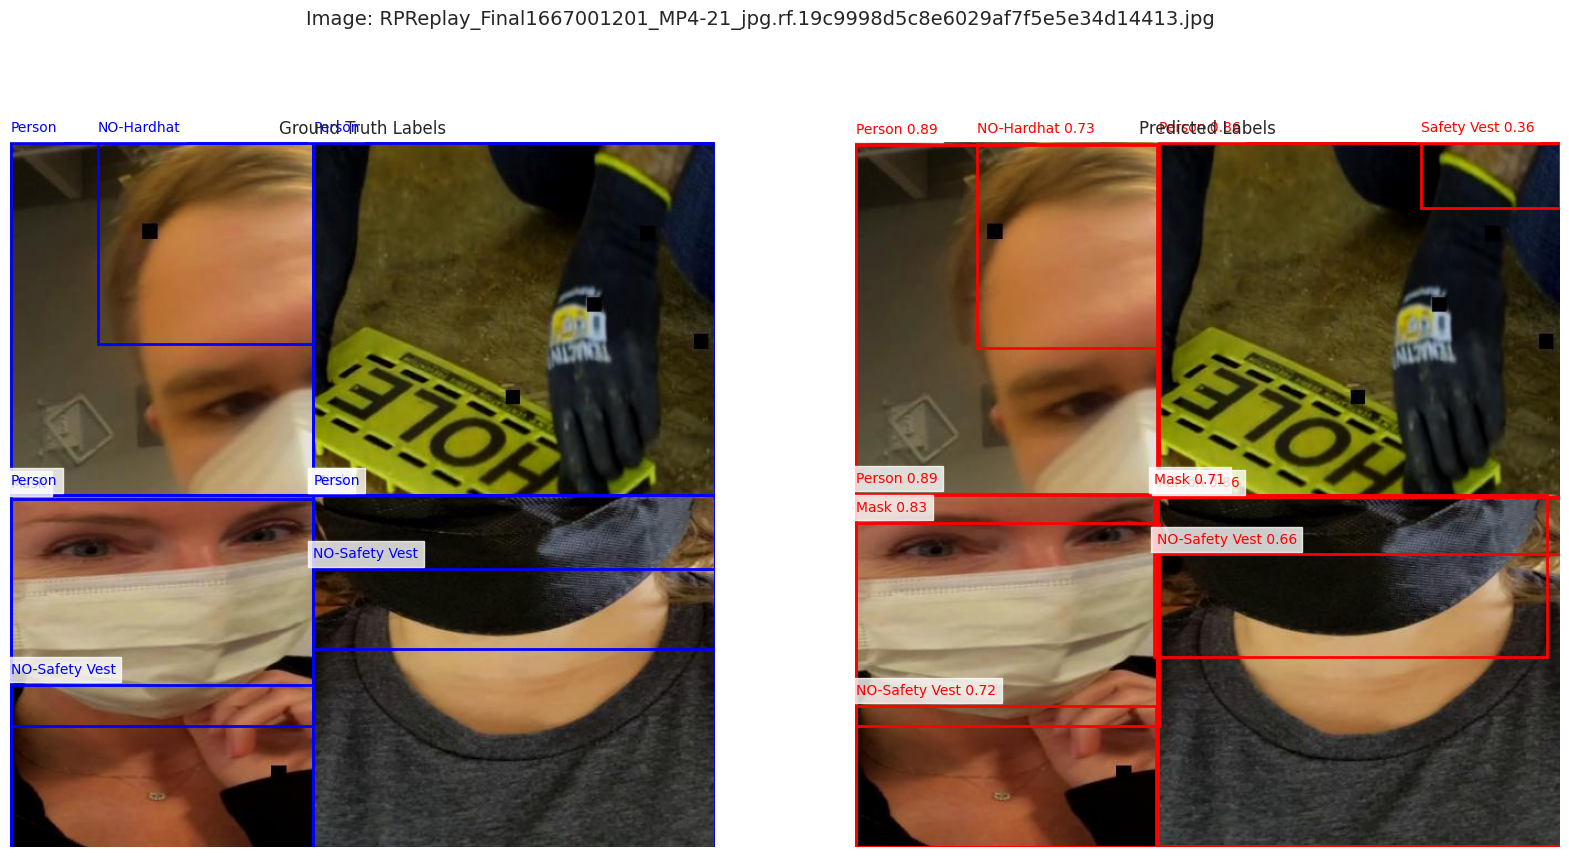

Side-by-side image saved to: /kaggle/working/groundtruth_vs_predicted.jpg


In [44]:
import os
import random
import numpy as np
from ultralytics import YOLO
import matplotlib.pyplot as plt
import cv2

# Path to the trained model
model_path = '/kaggle/working/runs/detect/train/weights/best.pt'

# Load the trained YOLOv11n model
model = YOLO(model_path)

# Paths to the dataset images and labels (validation set)
image_dir = '/kaggle/working/valid/images'
label_dir = '/kaggle/working/valid/labels'

# Select a random image from the directory
image_files = [f for f in os.listdir(image_dir) if f.endswith(('.jpg', '.png'))]
if not image_files:
    raise FileNotFoundError("No images found in the specified directory")
image_filename = random.choice(image_files)
image_path = os.path.join(image_dir, image_filename)

# Corresponding label file
label_filename = image_filename.rsplit('.', 1)[0] + '.txt'
label_path = os.path.join(label_dir, label_filename)

# Load the image
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
img_height, img_width = image.shape[:2]

# Function to draw bounding boxes and labels
def draw_boxes(image, boxes, class_names, color='red', is_ground_truth=False):
    img_copy = image.copy()
    for box in boxes:
        if is_ground_truth:
            # Ground truth: [class_id, x_center, y_center, width, height] (normalized)
            class_id, x_center, y_center, width, height = box
            class_id = int(class_id)
            x_center, y_center, width, height = (
                x_center * img_width, y_center * img_height,
                width * img_width, height * img_height
            )
            x1 = x_center - width / 2
            y1 = y_center - height / 2
            x2 = x_center + width / 2
            y2 = y_center + height / 2
            confidence = None
        else:
            # Predictions: [x1, y1, x2, y2, conf, class_id]
            x1, y1, x2, y2, confidence, class_id = box
            class_id = int(class_id)
        
        # Draw bounding box
        rect = plt.Rectangle((x1, y1), x2 - x1, y2 - y1, fill=False, edgecolor=color, linewidth=2)
        plt.gca().add_patch(rect)

        # Add label
        label = f'{class_names[class_id]} {confidence:.2f}' if confidence is not None else class_names[class_id]
        plt.text(x1, y1 - 10, label, color=color, fontsize=10, bbox=dict(facecolor='white', alpha=0.8))

# Read ground truth labels
ground_truth_boxes = []
if os.path.exists(label_path):
    with open(label_path, 'r') as f:
        for line in f:
            class_id, x_center, y_center, width, height = map(float, line.strip().split())
            ground_truth_boxes.append([class_id, x_center, y_center, width, height])
else:
    print(f"Warning: Label file {label_path} not found. Showing image without ground truth labels.")

# Run inference for predictions
results = model.predict(source=image_path, save=False, conf=0.25, iou=0.45)
result = results[0]  # Single image prediction

# Extract predicted boxes [x1, y1, x2, y2, conf, class_id]
predicted_boxes = []
for box in result.boxes:
    x1, y1, x2, y2 = box.xyxy[0].cpu().numpy()
    confidence = box.conf[0].cpu().numpy()
    class_id = box.cls[0].cpu().numpy()
    predicted_boxes.append([x1, y1, x2, y2, confidence, class_id])

# Create side-by-side plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

# Plot ground truth on the left
plt.sca(ax1)
plt.imshow(image)
draw_boxes(image, ground_truth_boxes, model.names, color='blue', is_ground_truth=True)
plt.title('Ground Truth Labels')
plt.axis('off')

# Plot predictions on the right
plt.sca(ax2)
plt.imshow(image)
draw_boxes(image, predicted_boxes, model.names, color='red', is_ground_truth=False)
plt.title('Predicted Labels')
plt.axis('off')

plt.suptitle(f'Image: {image_filename}', fontsize=14)
plt.show()

# Save the side-by-side image
output_image_path = '/kaggle/working/groundtruth_vs_predicted.jpg'
fig.savefig(output_image_path, dpi=300, bbox_inches='tight')
plt.close()
print(f"Side-by-side image saved to: {output_image_path}")

In [45]:
import os
import zipfile
from IPython.display import FileLink, display

# Define the output directory and ZIP file path
output_dir = '/kaggle/working/'
zip_path = '/kaggle/working/output_files.zip'

# Create a ZIP file
with zipfile.ZipFile(zip_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
    # Walk through the output directory
    for root, dirs, files in os.walk(output_dir):
        for file in files:
            # Skip the ZIP file itself to avoid recursion
            if file != os.path.basename(zip_path):
                file_path = os.path.join(root, file)
                # Add file to ZIP with relative path
                zipf.write(file_path, os.path.relpath(file_path, output_dir))

print(f"ZIP file created at: {zip_path}")

# Generate a download link
file_link = FileLink(os.path.basename(zip_path))
display(file_link)

ZIP file created at: /kaggle/working/output_files.zip


/kaggle/working/output_files.zip

# Saving the model as a Dataset

In [46]:
# Saving the model as a Dataset
copyfile(CFG.MODEL_PATH, CFG.OUTPUT_MODEL_PATH)

'/kaggle/working//best.pt'

In [47]:
# Creating a metadata file
metadata = {
    "model": "YOLO11",
    "description": "Trained YOLO11 (yolo11n.pt) model on PPE detection dataset",
    "source": "Construction Site PPE detection w/ YOLO v11 notebook",
}
with open(CFG.METADATA_PATH, "w") as f:
    json.dump(metadata, f)

print(f"✅ Model saved to: {CFG.OUTPUT_MODEL_PATH}")

✅ Model saved to: /kaggle/working//best.pt


# 📌 Conclusion
---
Our **final trained YOLOv11n model** achieved **mAP50 of 70.72% and mAP50-95 of 46.72%**, demonstrating significant improvements in detecting PPE on construction sites. The results indicate that **fine-tuning hyperparameters** and **data augmentation strategies** positively impacted model performance.

Further improvements can be made by:
- Experimenting with **other augmentation techniques** to increase class diversity.
- Increasing **training epochs** to enhance model learning.
- Utilizing a **larger model**, such as YOLO11m.pt, if hardware resources allow.
- Testing on **real-world unseen images** to evaluate generalization.

With these refinements, the model can be further optimized for real-time PPE detection applications. 🚀

@misc{ construction-site-safety_dataset,
    title = { Construction Site Safety Dataset },
    type = { Open Source Dataset },
    author = { Roboflow Universe Projects },
    howpublished = { \url{ https://universe.roboflow.com/roboflow-universe-projects/construction-site-safety } },
    url = { https://universe.roboflow.com/roboflow-universe-projects/construction-site-safety },
    journal = { Roboflow Universe },
    publisher = { Roboflow },
    year = { 2023 },
    month = { feb },
    note = { visited on 2023-02-23 },
}
